In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from project import clean_data, get_scores_ridge

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data = clean_data(data)

In [4]:
target = data.SalePrice

In [5]:
data = data.drop('SalePrice', axis=1)

In [6]:
columns = data.columns

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = .3)

In [8]:
y_train_binned = [0 if price <= 120000 else 1 if price <= 200000 else 2 for price in y_train]
y_test_binned  = [0 if price <= 120000 else 1 if price <= 200000 else 2 for price in y_test]

In [9]:
X_train_num = pd.get_dummies(X_train, drop_first=True)
X_test_num  = pd.get_dummies(X_test, drop_first=True)

# Models

#### Since we do not have enough data to split also for validation set we will use k-fold for validation

# Classification

In [10]:
def get_validation_scores_clf(clf, X):
    
    scores = cross_validate(clf, X, y_train_binned, cv=5, n_jobs=-1, return_train_score=True,
                            scoring=['f1_macro', 'recall_macro', 'precision_macro', 'accuracy'])
    
    for score in ['train_f1_macro', 'train_recall_macro', 'train_precision_macro', 'train_accuracy',
                  'test_f1_macro', 'test_recall_macro', 'test_precision_macro', 'test_accuracy']:
        print(score, scores[score].mean())
        
    return scores

In [11]:
def get_test_score_clf(clf, columns=columns):
    clf.fit(X_train_num.loc[:,columns], y_train_binned)
    y_pred = clf.predict(X_test_num.loc[:,columns])
    
    f1 = f1_score(y_test_binned, y_pred, average='macro')
    accuracy = accuracy_score(y_test_binned, y_pred)
    recall = recall_score(y_test_binned, y_pred, average='macro')
    precision = precision_score(y_test_binned, y_pred, average='macro')
    
    print('f1_score (macro)', f1)
    print('accuracy_score', accuracy)
    print('recall_score (macro)', recall)
    print('precision_score (macro)', precision)
    
    return {'f1':f1, 'accuracy':accuracy, 'recall':recall, 'precision':precision}

### Dummy Classifier

In [12]:
clf_dummy = DummyClassifier('most_frequent')

In [13]:
val_scores_clf_dummy = get_validation_scores_clf(clf_dummy, X_train_num)

train_f1_macro 0.22524869862564012
train_recall_macro 0.3333333333333333
train_precision_macro 0.1700948452391081
train_accuracy 0.5102845357173242
test_f1_macro 0.2252502567594567
test_recall_macro 0.3333333333333333
test_precision_macro 0.17009735163169054
test_accuracy 0.5102920548950717


In [14]:
test_scores_clf_dummy = get_test_score_clf(clf_dummy)

f1_score (macro) 0.23725490196078433
accuracy_score 0.5525114155251142
recall_score (macro) 0.3333333333333333
precision_score (macro) 0.18417047184170474


/Users/tovaschwartz/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/Users/tovaschwartz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tovaschwartz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Random Forest Classifier

In [15]:
best_params_rfc={'max_depth': 20,
                 'min_samples_leaf': 3,
                 'min_samples_split': 8,
                 'n_estimators': 100}

In [16]:
rfc_features = ['GrLivArea', 'OverallQual', 'GarageArea', 'BsmtUnfSF', 'KitchenQual',
                'MiscVal', '2ndFlrSF', 'LotArea', 'GarageFinish', '1stFlrSF',
                'TotalBsmtSF']

In [17]:
clf_rf = RandomForestClassifier(**best_params_rfc)

In [18]:
val_scores_clf_rf = get_validation_scores_clf(clf_rf, X_train_num.loc[:,rfc_features])

train_f1_macro 0.9289252080520323
train_recall_macro 0.9164781388096562
train_precision_macro 0.9444173226365556
train_accuracy 0.9361003929797473
test_f1_macro 0.7947946724955514
test_recall_macro 0.7805193214293106
test_precision_macro 0.8171581831904767
test_accuracy 0.8110466012692974


In [19]:
test_scores_clf_rf = get_test_score_clf(clf_rf, rfc_features)

f1_score (macro) 0.8161222419093482
accuracy_score 0.8401826484018264
recall_score (macro) 0.7968377433618076
precision_score (macro) 0.8434618197058353


### SVC Classifier

In [20]:
best_params_svc = {'C': 0.01, 'gamma': 0.0001, 'kernel': 'linear'}

In [21]:
svc_features = ['BsmtFinType1', 'LotArea', 'YearRemodAdd', 'GrLivArea', '2ndFlrSF',
                '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1',
                'OpenPorchSF', 'Fireplaces', 'MSZoning', 'LotFrontage', 'OverallQual',
                'OverallCond', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'GarageFinish',
                'Neighborhood_Crawfor', 'EnclosedPorch', 'WoodDeckSF', 'MSSubClass',
                'GarageYrBlt', 'ScreenPorch', 'MiscVal', 'KitchenQual', 'MasVnrArea']

In [22]:
clf_svc = Pipeline([('scaler', StandardScaler()), ('classifier', SVC(**best_params_svc))])

In [23]:
val_scores_clf_svc = get_validation_scores_clf(clf_svc, X_train_num.loc[:, svc_features])

train_f1_macro 0.8554338377716132
train_recall_macro 0.8347929350945436
train_precision_macro 0.8857658857375718
train_accuracy 0.8677746154495882
test_f1_macro 0.8364489083901765
test_recall_macro 0.8162763078627702
test_precision_macro 0.8736747638507797
test_accuracy 0.8521286392842716


In [24]:
test_scores_clf_svc = get_test_score_clf(clf_svc, svc_features)

f1_score (macro) 0.8391661387901989
accuracy_score 0.8538812785388128
recall_score (macro) 0.8345139708776071
precision_score (macro) 0.8441647187159109


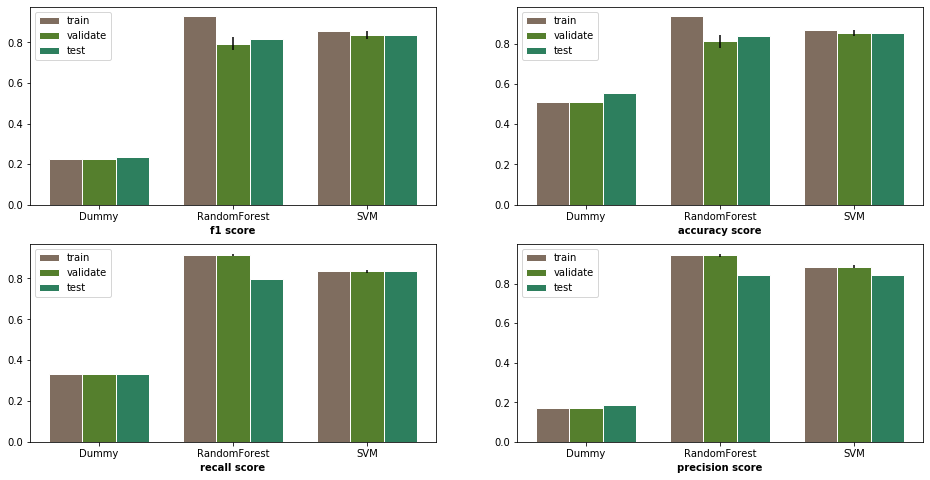

In [25]:
plt.figure(figsize=(16,8))
barWidth = 0.25

#f1
plt.subplot(2,2,1)
val_error = [val_scores_clf_dummy['test_f1_macro'].std(),
              val_scores_clf_rf['test_f1_macro'].std(),
              val_scores_clf_svc['test_f1_macro'].std()]

# set height of bar
train = [val_scores_clf_dummy['train_f1_macro'].mean(),
         val_scores_clf_rf['train_f1_macro'].mean(),
         val_scores_clf_svc['train_f1_macro'].mean()]
validation = [val_scores_clf_dummy['test_f1_macro'].mean(),
              val_scores_clf_rf['test_f1_macro'].mean(),
              val_scores_clf_svc['test_f1_macro'].mean()]
test = [test_scores_clf_dummy['f1'], test_scores_clf_rf['f1'], test_scores_clf_svc['f1']]

# Set position of bar on X axis
r1 = np.arange(len(train))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, train, color='#7f6d5f', width=barWidth, edgecolor='white', label='train')
plt.bar(r2, validation, color='#557f2d', width=barWidth, edgecolor='white', label='validate', yerr=val_error)
plt.bar(r3, test, color='#2d7f5e', width=barWidth, edgecolor='white', label='test')
 
# Add xticks on the middle of the group bars
plt.xlabel('f1 score', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(train))], ['Dummy', 'RandomForest', 'SVM'])
plt.legend()

#accuracy
plt.subplot(2,2,2)
val_error = [val_scores_clf_dummy['test_accuracy'].std(),
              val_scores_clf_rf['test_accuracy'].std(),
              val_scores_clf_svc['test_accuracy'].std()]

# set height of bar
train = [val_scores_clf_dummy['train_accuracy'].mean(),
         val_scores_clf_rf['train_accuracy'].mean(),
         val_scores_clf_svc['train_accuracy'].mean()]
validation = [val_scores_clf_dummy['test_accuracy'].mean(),
              val_scores_clf_rf['test_accuracy'].mean(),
              val_scores_clf_svc['test_accuracy'].mean()]
test = [test_scores_clf_dummy['accuracy'], test_scores_clf_rf['accuracy'], test_scores_clf_svc['accuracy']]

# Set position of bar on X axis
r1 = np.arange(len(train))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, train, color='#7f6d5f', width=barWidth, edgecolor='white', label='train')
plt.bar(r2, validation, color='#557f2d', width=barWidth, edgecolor='white', label='validate', yerr=val_error)
plt.bar(r3, test, color='#2d7f5e', width=barWidth, edgecolor='white', label='test')
 
# Add xticks on the middle of the group bars
plt.xlabel('accuracy score', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(train))], ['Dummy', 'RandomForest', 'SVM'])
plt.legend()

#recall
plt.subplot(2,2,3)
val_error = [val_scores_clf_dummy['train_recall_macro'].std(),
              val_scores_clf_rf['train_recall_macro'].std(),
              val_scores_clf_svc['train_recall_macro'].std()]

# set height of bar
train = [val_scores_clf_dummy['train_recall_macro'].mean(),
         val_scores_clf_rf['train_recall_macro'].mean(),
         val_scores_clf_svc['train_recall_macro'].mean()]
validation = [val_scores_clf_dummy['train_recall_macro'].mean(),
              val_scores_clf_rf['train_recall_macro'].mean(),
              val_scores_clf_svc['train_recall_macro'].mean()]
test = [test_scores_clf_dummy['recall'], test_scores_clf_rf['recall'], test_scores_clf_svc['recall']]

# Set position of bar on X axis
r1 = np.arange(len(train))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, train, color='#7f6d5f', width=barWidth, edgecolor='white', label='train')
plt.bar(r2, validation, color='#557f2d', width=barWidth, edgecolor='white', label='validate', yerr=val_error)
plt.bar(r3, test, color='#2d7f5e', width=barWidth, edgecolor='white', label='test')
 
# Add xticks on the middle of the group bars
plt.xlabel('recall score', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(train))], ['Dummy', 'RandomForest', 'SVM'])
plt.legend()

#precision
plt.subplot(2,2,4)
val_error = [val_scores_clf_dummy['train_precision_macro'].std(),
              val_scores_clf_rf['train_precision_macro'].std(),
              val_scores_clf_svc['train_precision_macro'].std()]

# set height of bar
train = [val_scores_clf_dummy['train_precision_macro'].mean(),
         val_scores_clf_rf['train_precision_macro'].mean(),
         val_scores_clf_svc['train_precision_macro'].mean()]
validation = [val_scores_clf_dummy['train_precision_macro'].mean(),
              val_scores_clf_rf['train_precision_macro'].mean(),
              val_scores_clf_svc['train_precision_macro'].mean()]
test = [test_scores_clf_dummy['precision'], test_scores_clf_rf['precision'], test_scores_clf_svc['precision']]

# Set position of bar on X axis
r1 = np.arange(len(train))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, train, color='#7f6d5f', width=barWidth, edgecolor='white', label='train');
plt.bar(r2, validation, color='#557f2d', width=barWidth, edgecolor='white', label='validate', yerr=val_error);
plt.bar(r3, test, color='#2d7f5e', width=barWidth, edgecolor='white', label='test');
 
# Add xticks on the middle of the group bars
plt.xlabel('precision score', fontweight='bold');
plt.xticks([r + barWidth for r in range(len(train))], ['Dummy', 'RandomForest', 'SVM']);
plt.legend();



# Regression

In [26]:
y_train_log = np.log(y_train)

In [27]:
y_test_log = np.log(y_test)

In [28]:
def get_validation_scores_reg(reg, X):
    
    scores = cross_validate(reg, X, y_train_log, cv=5, n_jobs=-1, return_train_score=True)
    
    for score in ['train_score', 'test_score']:
        print(score, scores[score].mean())
        
    return scores

In [29]:
def get_test_score_reg(reg, columns=columns):
    reg.fit(X_train_num.loc[:,columns], y_train_log)
    score = reg.score(X_test_num.loc[:,columns], y_test_log)
    
    print(score)
    return score

### Linear Regression

#### Ridge Regularization

In [30]:
lr_features = ['BsmtFinType1', 'LotArea', 'YearRemodAdd', 'GrLivArea', '2ndFlrSF',
               '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1',
               'OpenPorchSF', 'Fireplaces', 'MSZoning', 'LotFrontage', 'OverallQual',
               'OverallCond', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'GarageFinish',
               'Neighborhood_Crawfor', 'EnclosedPorch', 'WoodDeckSF', 'MSSubClass',
               'GarageYrBlt', 'ScreenPorch', 'MiscVal', 'KitchenQual', 'MasVnrArea']

In [31]:
reg_ridge = Pipeline([('scaler', StandardScaler()), ('estimator', Ridge(alpha=.05))])

In [32]:
val_scores_reg_ridge = get_validation_scores_reg(reg_ridge, X_train_num.loc[:,lr_features])

train_score 0.8952006196035335
test_score 0.878972257416309


In [33]:
test_score_reg_ridge = get_test_score_reg(reg_ridge, lr_features)

0.7973673827259827


#### Lasso Regularization

In [34]:
reg_lasso = Pipeline([('scaler', StandardScaler()), ('estimator', Lasso(alpha=.0005))])

In [35]:
val_scores_reg_lasso = get_validation_scores_reg(reg_lasso, X_train_num.loc[:,lr_features])

train_score 0.8951327886962408
test_score 0.8796530468218657


In [36]:
test_score_reg_lasso = get_test_score_reg(reg_lasso, lr_features)

0.7983009436235622


### Random Forest Regression

In [37]:
best_params_rf = {'max_depth': 30,
                  'min_samples_leaf': 1,
                  'min_samples_split': 2,
                  'n_estimators': 300}

In [38]:
rf_features = ['GrLivArea', '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'BsmtFinSF1',
               'OverallQual', '2ndFlrSF', 'LotArea', 'YearBuilt', 'BsmtUnfSF',
               'MasVnrArea', 'BsmtQual', 'OverallCond', 'MiscVal', 'KitchenQual',
               'GarageFinish']

In [39]:
reg_rf = RandomForestRegressor(**best_params_rf)

In [40]:
val_scores_reg_rf = get_validation_scores_reg(reg_rf, X_train_num.loc[:, rf_features])

train_score 0.9799532927987726
test_score 0.856652731095538


In [41]:
test_score_reg_rf = get_test_score_reg(reg_rf, rf_features)

0.8722860586630435


### SVM Regression

In [42]:
best_params_svr = {'C': 0.1, 'kernel': 'linear'}

In [43]:
svr_features = ['BsmtFinType1', 'LotArea', 'YearRemodAdd', 'GrLivArea', '2ndFlrSF',
                '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1',
                'OpenPorchSF', 'Fireplaces', 'MSZoning', 'LotFrontage', 'OverallQual',
                'OverallCond', 'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'GarageFinish',
                'Neighborhood_Crawfor', 'EnclosedPorch', 'WoodDeckSF', 'MSSubClass',
                'GarageYrBlt', 'ScreenPorch', 'MiscVal', 'KitchenQual', 'MasVnrArea']

In [44]:
reg_svr = Pipeline([('scaler', StandardScaler()), ('estimator', SVR(**best_params_svr))])

In [45]:
val_scores_reg_svr = get_validation_scores_reg(reg_svr, X_train_num.loc[:, svr_features])

train_score 0.8930723208495637
test_score 0.8805563123285083


In [46]:
test_score_reg_svr = get_test_score_reg(reg_svr, svr_features)

0.7831101316808665


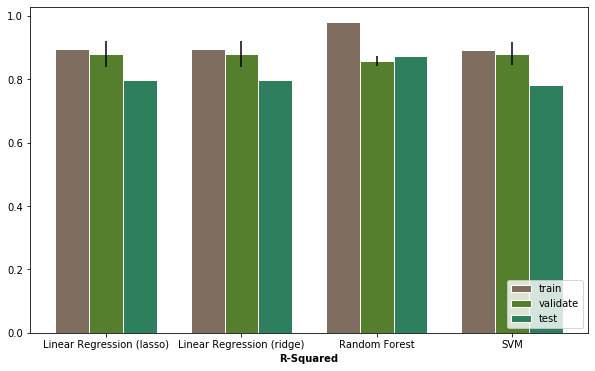

In [47]:
plt.figure(figsize=(10,6))
barWidth = 0.25
val_error = [val_scores_reg_lasso['test_score'].std(),
             val_scores_reg_ridge['test_score'].std(),
             val_scores_reg_rf['test_score'].std(),
             val_scores_reg_svr['test_score'].std()]

# set height of bar
train = [val_scores_reg_lasso['train_score'].mean(),
         val_scores_reg_ridge['train_score'].mean(),
         val_scores_reg_rf['train_score'].mean(),
         val_scores_reg_svr['train_score'].mean()]
validation = [val_scores_reg_lasso['test_score'].mean(),
              val_scores_reg_ridge['test_score'].mean(),
              val_scores_reg_rf['test_score'].mean(),
              val_scores_reg_svr['test_score'].mean()]
test = [test_score_reg_lasso, test_score_reg_ridge, test_score_reg_rf, test_score_reg_svr]

# Set position of bar on X axis
r1 = np.arange(len(train))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, train, color='#7f6d5f', width=barWidth, edgecolor='white', label='train')
plt.bar(r2, validation, color='#557f2d', width=barWidth, edgecolor='white', label='validate', yerr=val_error)
plt.bar(r3, test, color='#2d7f5e', width=barWidth, edgecolor='white', label='test')
 
# Add xticks on the middle of the group bars
plt.xlabel('R-Squared', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(train))], ['Linear Regression (lasso)',
                                                       'Linear Regression (ridge)', 
                                                       'Random Forest',
                                                       'SVM'])
plt.legend(loc=4)